<a href="https://colab.research.google.com/github/wdwzyyg/Atom-Finder/blob/main/Sergei's_AtomNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Atom Finder

**Notebook prepared by Maxim Ziatdinov**

Contact e-mail: ziatdinovmax@gmail.com

In [2]:
nbtype = !python -c "import google.colab" 2>/dev/null; echo $?
if not int(nbtype[0]):
    !git clone https://github.com/pycroscopy/AICrystallographer.git
    !cp -r AICrystallographer/AtomNet/* .

Cloning into 'AICrystallographer'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 1701 (delta 58), reused 30 (delta 13), pack-reused 1597
Receiving objects: 100% (1701/1701), 168.26 MiB | 27.06 MiB/s, done.
Resolving deltas: 100% (949/949), done.
Checking out files: 100% (276/276), done.


Import modules:

In [4]:
import os
import sys
import math
from os.path import exists
import numpy as np
import matplotlib.pyplot as plt
import dcnn
from atomfind import *

from scipy import ndimage as ndi
from scipy import optimize
import scipy.io as scio
from PIL import Image, ImageDraw
from skimage.filters import sobel
from skimage.measure import regionprops
from skimage.feature import peak_local_max
from skimage.morphology import opening, watershed, disk, erosion, local_maxima
import h5py
import glob
from pylab import *


def map01(mat):
    return (mat - mat.min())/(mat.max() - mat.min())
#imgdata = (map01(data) * 255).astype('uint8')
#imgdata = (map01(data) * 65535).astype('uint8')

## Get scores from own data

In [5]:
def getScores(predictpos_x, predictpos_y, truthpos_x, truthpos_y, truthnum, tolerance):
  truepoints = []
  pos_se = 0
  tp = 0
  #A_per_px = 25/256 
  # So about 10 px/Angstrom.Considering the atom radius, peak 0.5 angstrom as coordinate limitation, so 5 px or so

  for i in range(predictpos_x.size):
    for j in range(truthpos_x.size):
      square_error = (predictpos_x[i] - truthpos_x[j])**2 + (predictpos_y[i] - truthpos_y[j])**2
      if square_error < tolerance:
        truepoints.append((predictpos_y[i],predictpos_x[i]))
        pos_se = pos_se + square_error
        tp = tp + 1

  srmse = sqrt(pos_se / tp)
  recall = tp / truthnum
  precision = tp / predictpos_x.size
  print('srmse = ', srmse, 'px, recall = ', tp, '/', truthnum, ' = ', recall, ', precision = ', tp, '/', predictpos_x.size, ' = ', precision)
  scores = (srmse, recall, precision)
  return scores 

In [ ]:
totalmse = 0
totalr = 0
totalp= 0
filenum = 0
datapath = '/content/drive/MyDrive/AtomfinderProject/Data/Diffdistortion/flybackerror/Sergei/'
f= open(datapath+'Scores.txt','w+')
f.write('filename ID-recall ID-precision Pos-accuracy(px)\r\n')
f.close()

1 image was decoded in approximately 4.09 seconds
Atomic/defect coordinates extracted


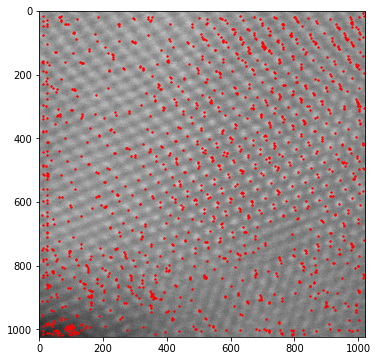

In [ ]:
system_type='cubic'
img = Image.open('/content/drive/MyDrive/TitanBackup/20201207/111_14d5M_1.tif')
imgdata = np.asarray(img)

# load model
model = dcnn.load_torchmodel(system_type)
# Apply a trained model to the loaded data
img, dec = dl_image(imgdata, model).decode()
# Get atomic coordinates:
coord = find_atoms(dec).get_all_coordinates()    

predictpos_y, predictpos_x, _ = coord[0].T
fig = figure(figsize=(6,6))
plt.imshow(imgdata, cmap = 'gray')
plt.scatter(predictpos_x,predictpos_y,s = 2, c = 'red')

1 image was decoded in approximately 0.22 seconds
Atomic/defect coordinates extracted
srmse =  0.9592518560032058 px, recall =  331 / 392  =  0.8443877551020408 , precision =  331 / 362  =  0.914364640883978


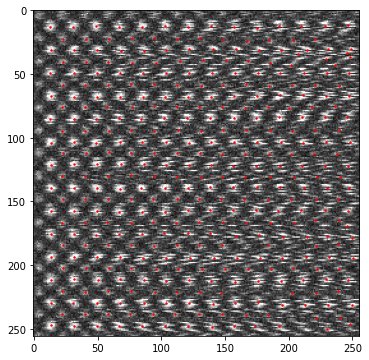

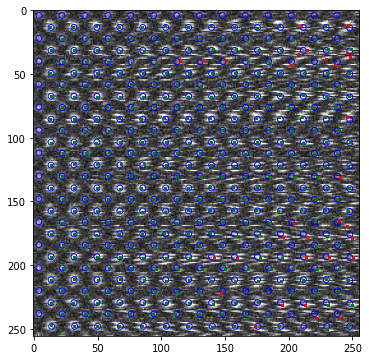

In [20]:
system_type='cubic'
datapath = '/content/drive/MyDrive/AtomfinderProject/Data/Diffdistortion/randomdrift/Sergei/'
path ='/content/drive/MyDrive/AtomfinderProject/Data/Diffdistortion/randomdrift/0.17R0.5F/'
#filename = '03'
A_per_px = 0.216
tolerance = 5  # set the max square distance we assume right found

mse = 0
r = 0
p = 0

# Use these if to get the only tif in file
for root, dirs, files in os.walk(path):
  for name in files:
    if name[-3:] =='tif':
      filename, _ = os.path.splitext(name) # HAADF_000
im = Image.open(path + filename + '.tif')
#im = Image.open(path)
imgdata = np.asarray(im)

# load model
model = dcnn.load_torchmodel(system_type)
# Apply a trained model to the loaded data
img, dec = dl_image(imgdata, model).decode()
# Get atomic coordinates:
coord = find_atoms(dec).get_all_coordinates()    

predictpos_y, predictpos_x, _ = coord[0].T

'''#delete predictions at edges
shape = imgdata.shape
dellistx = []
for i, coordx in enumerate (predictpos_x):
  dis = abs(coordx-shape[1])/shape[1]
  if dis>0.99 or dis<0.01:
    dellistx.append(i)
dellisty = []
for i, coordy in enumerate (predictpos_y):
  dis = abs(coordy-shape[0])/shape[0]
  if dis>0.99 or dis<0.01:
    dellisty.append(i)
dellist = dellistx +dellisty
dellist = np.unique(np.asarray(dellist))
predictpos_x = np.delete(predictpos_x,dellist)
predictpos_y = np.delete(predictpos_y,dellist)'''

truthpos_x = np.load(path+"Peaks_x.npy")
truthpos_y = np.load(path+"Peaks_y.npy")
#truthpos_x = np.load('/content/drive/MyDrive/AtomfinderProject/Data/DiffContrast/simulate/direct/Peaks_x.npy')
#truthpos_y = np.load('/content/drive/MyDrive/AtomfinderProject/Data/DiffContrast/simulate/direct/Peaks_y.npy')
truthnum = truthpos_x.shape[0]

fig = figure(figsize=(6,6))
plt.imshow(imgdata, cmap = 'gray')
plt.scatter(predictpos_x,predictpos_y,s = 2, c = 'red')
plt.savefig(datapath+filename+'.png')

srmse, r, p = getScores(predictpos_x, predictpos_y, truthpos_x, truthpos_y, truthnum, tolerance)
#f=open(datapath+'Scores.txt', "a+")
#f.write(('%s %5.4f %5.4f %5.4f \r\n' % (filename, r, p, srmse)))
#f.write(('Pixel size is %5.4f A, tolerance is %d \r\n' % (A_per_px, tolerance)))
#f.close()
#totalmse = totalmse + srmse
#totalr = totalr + r
#totalp= totalp + p
#filenum = filenum+1

del_index = []
truepoints_x = []
truepoints_y = []
for i in range(predictpos_x.size):
    for j in range(truthpos_x.size):
      square_error = (predictpos_x[i] - truthpos_x[j])**2 + (predictpos_y[i] - truthpos_y[j])**2
      if square_error < tolerance:
        truepoints_x.append(predictpos_x[i])
        truepoints_y.append(predictpos_y[i])
        del_index.append(i)

#Show false negtive points(precision)
FN_x = np.delete(predictpos_x, del_index)
FN_y = np.delete(predictpos_y, del_index)

fig = plt.figure(figsize=(6,6))
plt.imshow(imgdata, cmap = 'gray')
plt.scatter(truthpos_x, truthpos_y,s = 35, facecolors='none', edgecolors='blue')
plt.scatter(FN_x, FN_y,s = 2, c = 'red', marker=',')
plt.scatter(truepoints_x, truepoints_y, s = 2, c = 'g', marker=',')
# Show true negtive points(recall)
plt.savefig(datapath+filename+'color.png')

In [ ]:

# code for get scores by loop over folders of image

A_per_px = 0.216
tolerance = 5  # set the max square distance we assume right found
system_type='cubic'

truthpath = '/content/drive/MyDrive/AtomfinderProject/Data/Diffdistortion/flybackerror/NEW/'
folderlist = sort(os.listdir(truthpath))
datapath = '/content/drive/MyDrive/AtomfinderProject/Data/Diffdistortion/flybackerror/Sergei/'
mse = 0
r = 0
p = 0
totalmse = 0
totalr = 0
totalp= 0
filenum = 0
#f= open(datapath+'Scores.txt','w+')
#f.write('filename ID-recall ID-precision Pos-accuracy(px)\r\n')
#f.write(('Pixel size is %5.4f A, tolerance is %5.2f \r\n' % (A_per_px, tolerance)))

for folder in folderlist:
  files = os.listdir(truthpath+folder+'/')
  for file in files:
    filename,surfix = os.path.splitext(file)
    if surfix == '.png':
      im = Image.open(truthpath+folder+'/'+file) 
      imgdata = np.asarray(im)

      # load model
      model = dcnn.load_torchmodel(system_type)
      # Apply a trained model to the loaded data
      img, dec = dl_image(imgdata, model).decode()
      # Get atomic coordinates:
      coord = find_atoms(dec).get_all_coordinates()    

      predictpos_y, predictpos_x, _ = coord[0].T

      #delete predictions at edges
      shape = imgdata.shape
      dellistx = []
      for i, coordx in enumerate (predictpos_x):
        dis = abs(coordx-shape[1])/shape[1]
        if dis>0.99 or dis<0.01:
          dellistx.append(i)
      dellisty = []
      for i, coordy in enumerate (predictpos_y):
        dis = abs(coordy-shape[0])/shape[0]
        if dis>0.99 or dis<0.01:
          dellisty.append(i)
      dellist = dellistx +dellisty
      dellist = np.unique(np.asarray(dellist))
      predictpos_x = np.delete(predictpos_x,dellist)
      predictpos_y = np.delete(predictpos_y,dellist)

      #truthpos_x = np.load(truthpath+folder+'/Peaks_x.npy')
      #truthpos_y = np.load(truthpath+folder+'/Peaks_y.npy')
      truthpos_x = np.load(truthpath+'Peaks_x.npy')
      truthpos_y = np.load(truthpath+'Peaks_y.npy')
      truthnum = truthpos_x.shape[0]

      fig = plt.figure(figsize=(6,6))
      plt.imshow(imgdata, cmap = 'gray')
      plt.scatter(predictpos_x,predictpos_y,s = 2, c = 'red')
      plt.savefig(datapath+filename+'.png')

      srmse, r, p = getScores(predictpos_x, predictpos_y, truthpos_x, truthpos_y, truthnum, tolerance)

      #f=open(datapath+'Scores.txt', "a+")
      #f.write(('%s %5.4f %5.4f %5.4f \r\n' % (filename, r, p, srmse)))
      #f.close()

      totalmse = totalmse + srmse
      totalr = totalr + r
      totalp= totalp + p
      filenum = filenum+1

      del_index = []
      truepoints_x = []
      truepoints_y = []
      for i in range(predictpos_x.size):
          for j in range(truthpos_x.size):
            square_error = (predictpos_x[i] - truthpos_x[j])**2 + (predictpos_y[i] - truthpos_y[j])**2
            if square_error < tolerance:
              truepoints_x.append(predictpos_x[i])
              truepoints_y.append(predictpos_y[i])
              del_index.append(i)

      #Show false negtive points(precision)
      FN_x = np.delete(predictpos_x, del_index)
      FN_y = np.delete(predictpos_y, del_index)

      #fig = plt.figure(figsize=(6,6))
      #plt.imshow(imgdata, cmap = 'gray')
      #plt.scatter(truthpos_x, truthpos_y,s = 35, facecolors='none', edgecolors='blue')
      #plt.scatter(FN_x, FN_y,s = 2, c = 'red', marker=',')
      #plt.scatter(truepoints_x, truepoints_y, s = 2, c = 'g', marker=',')
      ## Show true negtive points(recall)
      #plt.savefig(datapath+filename+'color.png')

In [ ]:
print('Over', filenum, 'files, mse = ', totalmse/filenum, 'px^2, recall = ',totalr/filenum, ', precision = ', totalp/filenum)
#f=open(datapath+'Scores.txt', "a+")
f.write('Over %d files, recall = %d, precision = %d, mse = %d px' % (filenum, totalr/filenum, totalp/filenum, totalmse/filenum,))
f.close()

## Visual result from maria's simulation data

Load simulation data: npy file from h5

In [ ]:
#Load image as numpy array and print its dimensions

h5file = h5py.File('/content/AtomSegNet/Uniform/000014.010101.h5', 'r')
print("Chemical Formula  :", h5file.attrs['chemical_formula'].decode("utf-8") )
print("ICSD CollCode     :", h5file.attrs['icsd_collcode'].decode("utf-8") )
print("Zone Axis [uvw]   :", h5file.attrs['uvw_direction'].decode("utf-8") )
print("Distortion types: ",list(h5file['haadf'].keys()))
clean_img = np.array(h5file['haadf']['stem00-blbk1'])
data = np.array(clean_img, dtype='float64')

imgdata = (map01(data) * 255).astype('uint8')

print("Image data dimensions:", imgdata.shape)
print("Image data type:", imgdata.dtype)

Chemical Formula  : 'Li Nd (P4 O12)'
ICSD CollCode     : 14
Zone Axis [uvw]   : (1.0, 1.0, 1.0)
Distortion types:  ['peak_map_clean', 'raw', 'stem00-blbk1', 'stem00-clean']
Image data dimensions: (256, 256)
Image data type: uint8


Load model:

In [ ]:
# specify system/lattice type (currently available: graphene, graphene-si, cubic)
system_type='cubic'
# load model
model = dcnn.load_torchmodel(system_type)
print('Loaded model for the following system:', system_type)

Loaded model for the following system: cubic


Apply a trained model to the experimental data and extract atomic coordinates

In [ ]:
# Apply a trained model to the loaded data
img, dec = dl_image(imgdata, model).decode()
# Get atomic coordinates:
coord = find_atoms(dec).get_all_coordinates()

1 image was decoded in approximately 0.31 seconds
Atomic/defect coordinates extracted


Plot the results:

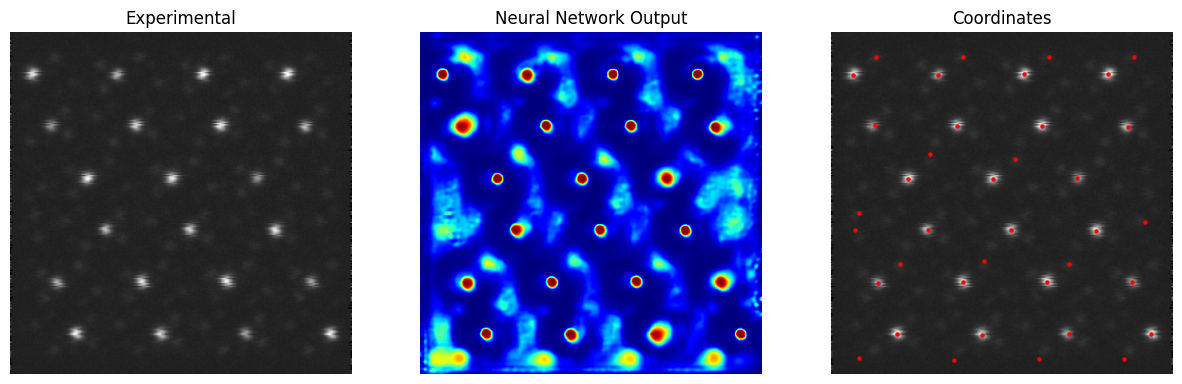

In [ ]:
# Plot results ( for image stack (movie), plots the first image (frame) )
k = 0
y, x, _ = coord[0].T
fig, ax = plt.subplots(1, 3, figsize = (15, 5), dpi=100)
ax[0].imshow(img[k, :, :, 0], cmap='gray')
ax[0].set_title('Experimental')
ax[1].imshow(dec[k, :, :, 0], cmap='jet', Interpolation='Gaussian')
ax[1].set_title('Neural Network Output')
ax[2].imshow(img[k, :, :, 0], cmap='gray')
ax[2].scatter(x, y, s=5, c='red')
ax[2].set_title('Coordinates')
for _ax in fig.axes:
    _ax.axis('off')
plt.show()



1.00001.00dgbdil## Get scores from simulation data

In [ ]:
def getScores(predictpos_x, predictpos_y, truthpos_x, truthpos_y, truthnum, tolerance):
  truepoints = []
  pos_se = 0
  tp = 0
  #A_per_px = 25/256 
  # So about 10 px/Angstrom.Considering the atom radius, peak 0.5 angstrom as coordinate limitation, so 5 px or so

  for i in range(predictpos_x.size):
    for j in range(truthpos_x.size):
      square_error = (predictpos_x[i] - truthpos_x[j])**2 + (predictpos_y[i] - truthpos_y[j])**2
      if square_error < tolerance:
        truepoints.append((predictpos_y[i],predictpos_x[i]))
        pos_se = pos_se + square_error
        tp = tp + 1

  srmse = math.sqrt(pos_se / tp)
  recall = tp / truthnum
  precision = tp / predictpos_x.size
  print('srmse = ', srmse, 'px, recall = ', tp, '/', truthnum, ' = ', recall, ', precision = ', tp, '/', predictpos_x.size, ' = ', precision)
  scores = (srmse, recall, precision)
  return scores 

In [ ]:
truthpath = '/content/AtomSegNet/SimuDataH5/'
filelist = os.listdir(truthpath)

mse = 0
r = 0
p = 0
totalmse = 0
totalr = 0
totalp= 0

system_type='cubic'

for file in filelist:

   imagePath = truthpath + file
   filename,_ = os.path.splitext(file)

   h5file = h5py.File(imagePath, 'r')
   #print("Chemical Formula  :", h5file.attrs['chemical_formula'].decode("utf-8") )
   #print("ICSD CollCode     :", h5file.attrs['icsd_collcode'].decode("utf-8") )
   #print("Zone Axis [uvw]   :", h5file.attrs['uvw_direction'].decode("utf-8") )
   #print("Distortion types: ",list(h5file['haadf'].keys()))
   clean_img = np.array(h5file['haadf']['stem00-blbk1'])
   data = np.array(clean_img, dtype='float64')
   imgdata = (map01(data) * 255).astype('uint8')

   # load model
   model = dcnn.load_torchmodel(system_type)
   # Apply a trained model to the loaded data
   img, dec = dl_image(imgdata, model).decode()
   # Get atomic coordinates:
   coord = find_atoms(dec).get_all_coordinates()    
   
   predictpos_y, predictpos_x, _ = coord[0].T
   truthpos = np.nonzero(np.array(h5file['haadf']['peak_map_clean'])) 
   truthnum = np.count_nonzero(np.array(h5file['haadf']['peak_map_clean']))
   tolerance = 5   # set the max square distance we assume right found

   mse, r, p = getScores(predictpos_x, predictpos_y, truthpos, truthnum, tolerance)
   totalmse = totalmse + mse
   totalr = totalr + r
   totalp= totalp + p

print('Over 200 files, mse = ', totalmse/200, 'A^2, recall = ',totalr/200, ', precision = ', totalp/200)

000063.020211.h5
1 image was decoded in approximately 0.27 seconds
Atomic/defect coordinates extracted
(array([1288, 3546, 4564, 5144, 4598, 4112, 2702, 1234,  316,   52]), array([  0.        ,  30.78066835,  61.56133669,  92.34200504,
       123.12267338, 153.90334173, 184.68401007, 215.46467842,
       246.24534676, 277.02601511, 307.80668345]))
Standard Deviation of distances is 0.9350327956998582 


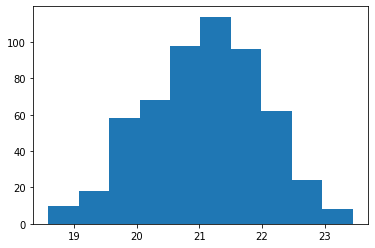

In [ ]:
# Calcute deviation should pick good image

from scipy.spatial import distance
import statistics

truthpath = '/content/AtomSegNet/Uniform/'
filelist = os.listdir(truthpath)

mse = 0
r = 0
p = 0
totalmse = 0
totalr = 0
totalp= 0

file = filelist[4]
print(file)

filename,_ = os.path.splitext(file)

imagePath = truthpath + file

h5file = h5py.File(imagePath, 'r')
#print("Chemical Formula  :", h5file.attrs['chemical_formula'].decode("utf-8") )
#print("ICSD CollCode     :", h5file.attrs['icsd_collcode'].decode("utf-8") )
#print("Zone Axis [uvw]   :", h5file.attrs['uvw_direction'].decode("utf-8") )
#print("Distortion types: ",list(h5file['haadf'].keys()))
clean_img = np.array(h5file['haadf']['stem00-clean'])
data = np.array(clean_img, dtype='float64')
imgdata = (map01(data) * 255).astype('uint8')

# load model
model = dcnn.load_torchmodel(system_type)
# Apply a trained model to the loaded data
img, dec = dl_image(imgdata, model).decode()
# Get atomic coordinates:
coord = find_atoms(dec).get_all_coordinates()    
   
predictpos_y, predictpos_x, _ = coord[0].T
truthpos = np.nonzero(np.array(h5file['haadf']['peak_map_clean'])) 
truthnum = np.count_nonzero(np.array(h5file['haadf']['peak_map_clean']))
tolerance = 5   # set the max square distance we assume right found

truepoints = []
A_per_px = 25/256 
# So about 10 px/Angstrom.Considering the atom radius, peak 0.5 angstrom as coordinate limitation, so 5 px or so

for i in range(predictpos_x.size):
  for c in zip(*truthpos):
    square_error = (predictpos_x[i] - c[1])**2 + (predictpos_y[i] - c[0])**2
    if square_error < tolerance:
      truepoints.append((predictpos_y[i],predictpos_x[i]))

distances = distance.cdist(truepoints, truepoints, 'euclidean')
print(np.histogram(distances))
#plt.imshow(img[0, :, :, 0], cmap='gray')
#plt.hist(distances)

distances_avai = distances[(distances < 25) & (distances > 18)]
plt.hist(distances_avai)


print("Standard Deviation of distances is % s " % (statistics.stdev(distances_avai))) 

## Check result with training data: works good

In [ ]:
# use a patch in this big image to test
download_link = 'https://drive.google.com/uc?id=1_uo7BXjDU-laUAs4Uj1aFqwqfnxi9tpz'
!gdown $download_link -O 'img_w_coord.npy'
img_w_coord = np.load('img_w_coord.npy')
lattice_im = img_w_coord['lattice_img']
xy_atoms_a = img_w_coord['lattice_coord_a']
xy_atoms_b = img_w_coord['lattice_coord_b']
print(lattice_im.shape, xy_atoms_a.shape, xy_atoms_b.shape)

In [ ]:
#Sadly the egde of the image has no coords, so choose a middle patch
#and the coords should be substract by e.g.1000
xy_atoms_a = xy_atoms_a[:, (xy_atoms_a[0]> 1001) & (xy_atoms_a[1]>1001)]
xy_atoms_a = xy_atoms_a[:, (xy_atoms_a[0]< 1300) & (xy_atoms_a[1]<1300)]
xy_atoms_b = xy_atoms_b[:, (xy_atoms_b[0]> 1001) & (xy_atoms_b[1]>1001)]
xy_atoms_b = xy_atoms_b[:, (xy_atoms_b[0]< 1300) & (xy_atoms_b[1]<1300)]
print(xy_atoms_a.shape,xy_atoms_b.shape)

(2, 542) (2, 546)


In [ ]:
xy_atoms_a = xy_atoms_a - 1001
xy_atoms_b = xy_atoms_b - 1001

Image size: (300, 300)
1 image was decoded in approximately 0.29 seconds
Atomic/defect coordinates extracted
real point:  1088
srmse =  1.3566398498960397 px, recall =  824 / 1088  =  0.7573529411764706 , precision =  824 / 825  =  0.9987878787878788


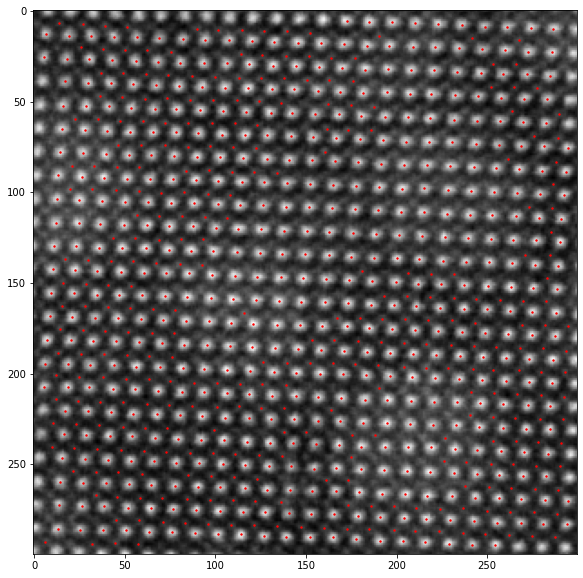

In [ ]:
system_type='cubic'
# load model
model = dcnn.load_torchmodel(system_type)
imgdata = lattice_im[999:1299,999:1299]
print('Image size:',imgdata.shape)
# Apply a trained model to the loaded data
img, dec = dl_image(imgdata, model).decode()
# Get atomic coordinates:
coord = find_atoms(dec).get_all_coordinates()    
predictpos_y, predictpos_x, _ = coord[0].T
fig = plt.figure(figsize=(10,10))
plt.imshow(imgdata, cmap = 'gray')
plt.scatter(predictpos_x,predictpos_y,s = 2, c = 'red')
truthpos_x = np.concatenate((xy_atoms_a, xy_atoms_b), axis=1)[1]
truthpos_y = np.concatenate((xy_atoms_a, xy_atoms_b), axis=1)[0]

truthnum = truthpos_x.shape[0]
print('real point: ',truthnum)
tolerance = 5   # set the max square distance we assume right found

srmse, r, p = getScores(predictpos_x, predictpos_y, truthpos_x, truthpos_y, truthnum, tolerance)


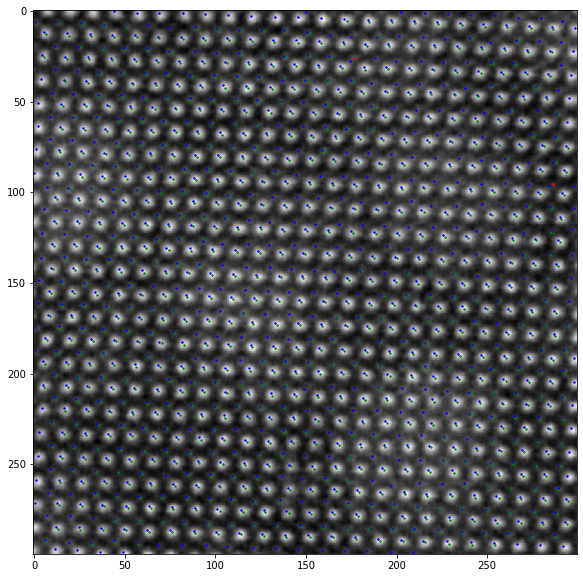

In [ ]:
del_index = []
truepoints_x = []
truepoints_y = []
for i in range(predictpos_x.size):
    for j in range(truthpos_x.size):
      square_error = (predictpos_x[i] - truthpos_x[j])**2 + (predictpos_y[i] - truthpos_y[j])**2
      if square_error < tolerance:
        truepoints_x.append(predictpos_x[i])
        truepoints_y.append(predictpos_y[i])
        del_index.append(i)

#Show false negtive points(precision)
FN_x = np.delete(predictpos_x, del_index)
FN_y = np.delete(predictpos_y, del_index)

fig = plt.figure(figsize=(10,10))
plt.imshow(imgdata, cmap = 'gray')
plt.scatter(FN_x, FN_y,s = 2, c = 'red')
plt.scatter(truthpos_x, truthpos_y,s = 2, c = 'blue')
plt.scatter(truepoints_x, truepoints_y, s = 2, c = 'g')
# Show true negtive points(recall)